## 4.2 Zeitreihenschätzung Inflationsrate USA

In [1]:
source("util.R")
suppressMessages({library(fpp3)})
suppressMessages({library(forecast)})
suppressMessages({library(quantmod)})

## Datenaufbereitung

Das Paket `quantmod` stellt ein einfaches Interface zum Zugriff auf die 
[Federal Reserve Economic Data (FRED)](https://fred.stlouisfed.org/) Datenbank zur Verfügung.
Der Datensatz `CPIAUCNS` enthält die Zeitreihe des *Consumer Price Index* der USA

In [2]:
cpi_data <- getSymbols("CPIAUCNS", 
                       src = "FRED", 
                       from='1971-01', to='2016-12', 
                       auto.assign = FALSE)

Aus den Daten des Consumer Price Index werden nun die Inflationsraten der Quartale berechnet

In [3]:
options(xts.message.period.apply.mean = FALSE)

inflation_rate <- diff(log(cpi_data))[-1] * 400
quarterly_inflation_rate <- apply.quarterly(inflation_rate, mean)
quarters <- yearquarter(zoo::index(quarterly_inflation_rate))
inflation_rate_df <- data.frame(Quarter=quarters, coredata(quarterly_inflation_rate$'CPIAUCNS'))
inflation_rate_tsibble <- as_tsibble(inflation_rate_df, index = Quarter)

## Zeitreihe Inflationsrate

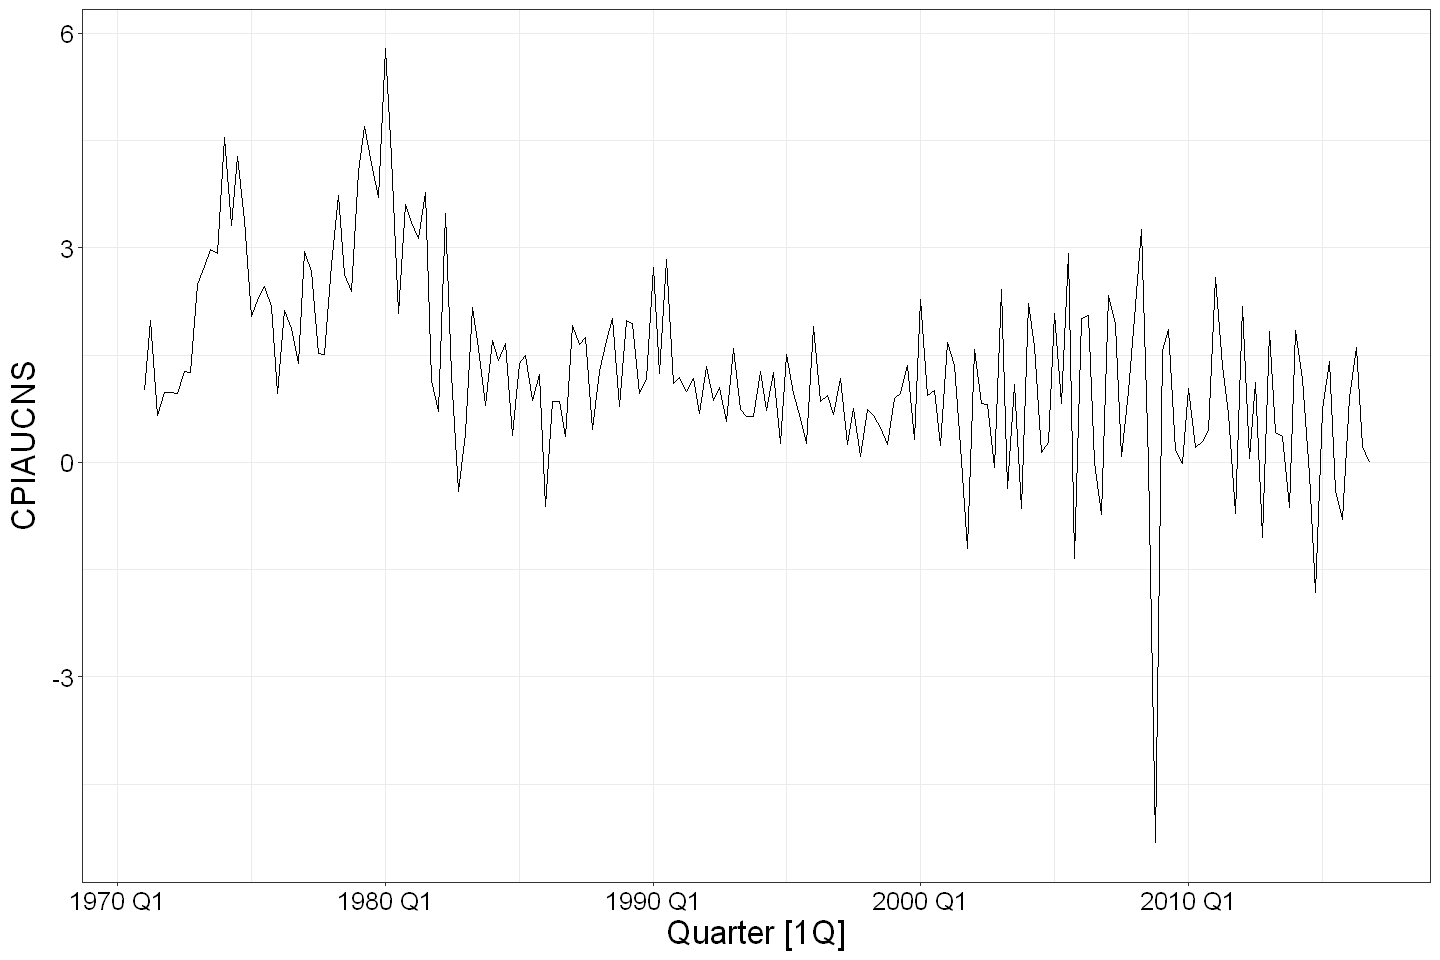

In [4]:
options(repr.plot.width=12, repr.plot.height=8)

inflation_rate_ts_plot <- inflation_rate_tsibble |> autoplot(CPIAUCNS) 
print(inflation_rate_ts_plot + theme_jupyter(axis_title_size=20))

## Schätzung Zeitreihenmodell
Die Routine `ARIMA` bestimmt das beste Zeitreihenmodell basierend auf den Informationskriterien AIC oder BIC

In [5]:
fit_inflation_rate <- inflation_rate_tsibble |> model(ARIMA(CPIAUCNS))

Geschätztes Modell

In [6]:
report(fit_inflation_rate)

Series: CPIAUCNS 
Model: ARIMA(0,1,1)(0,0,2)[4] 

Coefficients:
          ma1    sma1    sma2
      -0.8729  0.3484  0.1292
s.e.   0.0620  0.0815  0.0703

sigma^2 estimated as 1.1:  log likelihood=-267.6
AIC=543.21   AICc=543.43   BIC=556.04


## Residuen des Modell

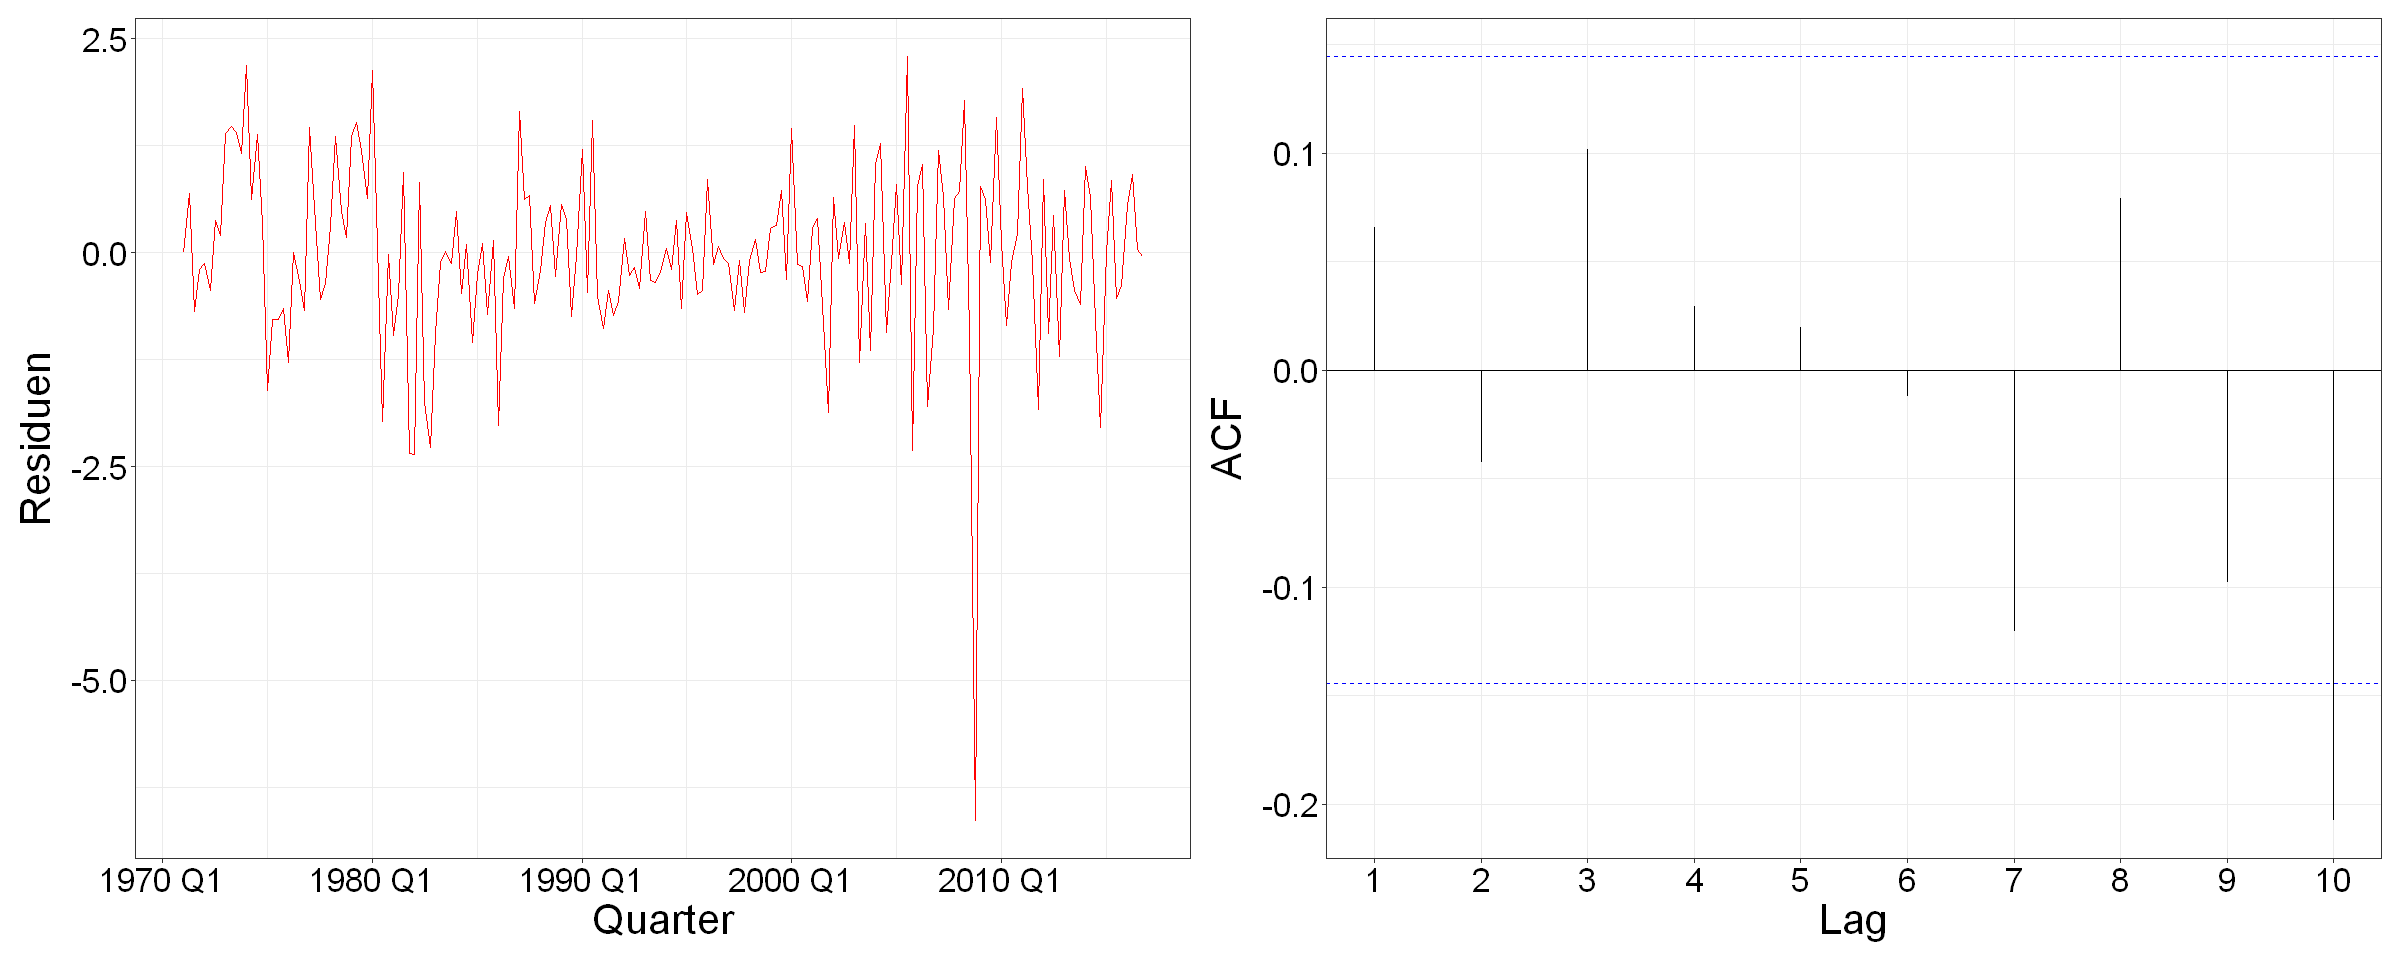

In [7]:
options(repr.plot.width=20, repr.plot.height=8)

residuals <- residuals(fit_inflation_rate)

residuals_ts_plot <- ggplot(residuals, aes(x = Quarter, y = .resid)) +
                     geom_line(color = "red") +
                     xlab("Quarter") +
                     ylab("Residuen") +
                     theme_jupyter()

acf_plot <- ggAcf(residuals$.resid, lag.max = 10) +
            ggtitle(NULL) +
            theme_jupyter()

residuals_plot <- residuals_ts_plot | acf_plot
print(residuals_plot)

## Q-Q Plot Residuen

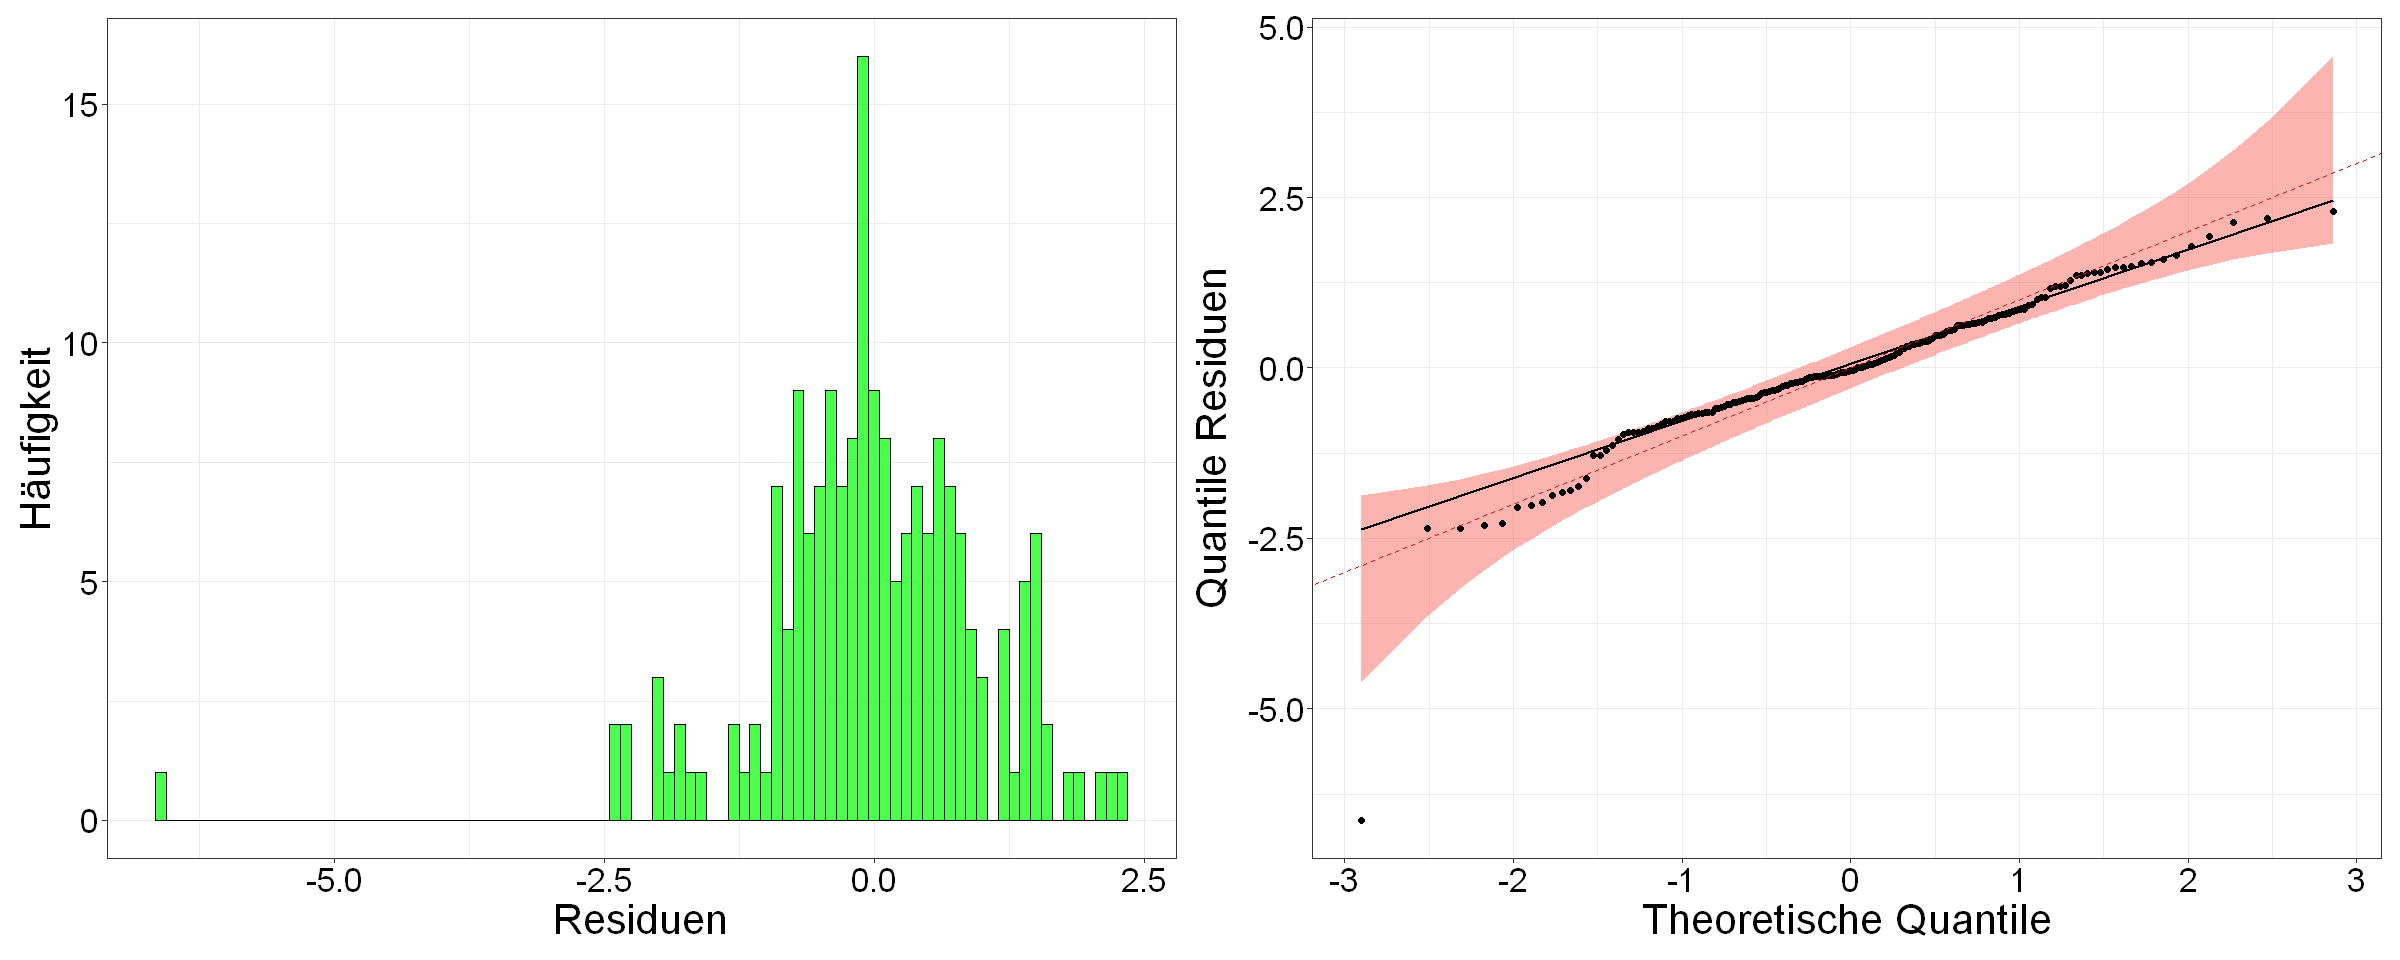

In [8]:
hist_plot <- ggplot(residuals, aes(x = .resid)) +
             geom_histogram(binwidth = 0.1, fill = "green", color = "black", alpha = 0.7) +
             xlab("Residuen") +
             ylab("Häufigkeit") +
             theme_jupyter()

qqplot <- ggplot(residuals, aes(sample = .resid)) +
                 stat_qq_band(bandType = "ell", mapping = aes(fill = "red", alpha = 0.5), show.legend = FALSE) +
                 stat_qq_point() +
                 stat_qq_line() +
                 geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
                 xlab("Theoretische Quantile") +
                 ylab("Quantile Residuen") +
                 theme_jupyter()

residuals_qqplot <- hist_plot | qqplot
print(residuals_qqplot)